# FINE TUNING

In [19]:
import d2l 
from mxnet import *
from mxnet.gluon import nn
npx.set_np()

In [20]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

In [21]:
data_dir = d2l.download_extract('hotdog')

In [22]:
import os

train_imgs = gluon.data.vision.ImageFolderDataset(
os.path.join(data_dir, 'train'))

test_imgs = gluon.data.vision.ImageFolderDataset(
os.path.join(data_dir, 'test'))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000013DC6DDC6C8>,
      dtype=object)

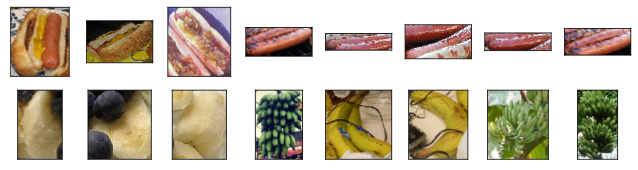

In [23]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i -1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale= 1.4)

In [24]:
normalize = gluon.data.vision.transforms.Normalize(
[0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomResizedCrop(224),
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor(),
    normalize
])

In [25]:
test_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(256),
    gluon.data.vision.transforms.CenterCrop(224),
    gluon.data.vision.transforms.ToTensor(),
    normalize
])

In [26]:
pretrained_net = gluon.model_zoo.vision.resnet18_v2(pretrained= True)
pretrained_net.output

Dense(512 -> 1000, linear)

In [27]:
finetune_net = gluon.model_zoo.vision.resnet18_v2(classes= 2)
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

In [28]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5):
    train_iter = gluon.data.DataLoader(
    train_imgs.transform_first(train_augs), batch_size, shuffle=True)
    test_iter = gluon.data.DataLoader(
    test_imgs.transform_first(test_augs), batch_size)
    ctx = d2l.try_all_gpus()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gluon.loss.SoftmaxCrossEntropyLoss(),
    trainer = gluon.Trainer(net.collect_params(), 'sgd', 
                           {'learning_rate': learning_rate, 'wd': 0.001})
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)

TypeError: 'tuple' object is not callable

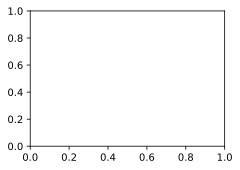

In [29]:
train_fine_tuning(finetune_net, 0.01)